# Parse all jsons into a the daily prices dataset

In [8]:
try:
    import mplfinance
except:
    ! pip install mplfinance
    import mplfinance
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm.auto import tqdm
from pprint import pprint
import logging
# set up logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# create a file handler
handler = logging.FileHandler('dataset_build.log')
handler.setLevel(logging.INFO)
# create a logging format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(handler)

Convert jsons into an easy to use dict

In [9]:
prices = {}
# iterate over all json files in the prices folder
for file in tqdm(os.listdir('prices')):
    # open the json file
    with open(os.path.join('prices', file)) as f:
        daily_stock = json.load(f)
        if 'Time Series (Daily)' not in daily_stock:
            logger.error('No time series data for {}'.format(file))
            continue
        prices[daily_stock['Meta Data']['2. Symbol']] = daily_stock['Time Series (Daily)']

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

<span style="color:red">TODO Later on extend the script to recapture stocks that the dataset_build log recorded as failures</span>

In [69]:
# create a row for each stock and date
rows = []
for stock, daily_prices in tqdm(prices.items()):
    for date, price in daily_prices.items():
        rows.append([stock, date, price['1. open'], price['2. high'], price['3. low'], price['4. close'], price['5. adjusted close'], price['6. volume'], price['7. dividend amount'], price['8. split coefficient']])
# create a dataframe from the rows
price_df = pd.DataFrame(rows, columns=['stock', 'date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'dividend', 'split'])
price_df['date'] = pd.to_datetime(price_df['date'])
# convert all columns to numeric except for the date and stock
price_df[price_df.columns[2:]] = price_df[price_df.columns[2:]].apply(pd.to_numeric, errors='coerce')

100%|██████████| 56/56 [00:00<00:00, 195.46it/s]


### Merge the new price dataset with the existing dataset

In [70]:
try:
    old_price_df = pd.read_csv('daily_prices.csv')
except FileNotFoundError:
    old_price_df = pd.DataFrame(columns=['stock', 'date', 'open', 'high', 'low', 'close', 'adj_close', 'volume', 'dividend', 'split'])
old_price_df['date'] = pd.to_datetime(old_price_df['date'])
old_price_df[old_price_df.columns[2:]] = old_price_df[old_price_df.columns[2:]].apply(pd.to_numeric, errors='coerce')
new_price_df = pd.concat([old_price_df, price_df], ignore_index=True).drop_duplicates(ignore_index=True).dropna(subset=['stock']).sort_values(['stock', 'date'])
# save the dataframe to a csv file
new_price_df.to_csv('daily_prices.csv', index=False)

In [71]:
new_price_df

,stock,date,open,high,low,close,adj_close,volume,dividend,split
0,AAPL,1999-11-01,80.00,80.69,77.370,77.62,0.589041,2487300,0.0,1.0
1,AAPL,1999-11-02,78.00,81.69,77.310,80.25,0.608999,3564600,0.0,1.0
2,AAPL,1999-11-03,81.62,83.25,81.000,81.50,0.618485,2932700,0.0,1.0
3,AAPL,1999-11-04,82.06,85.37,80.620,83.62,0.634574,3384700,0.0,1.0
4,AAPL,1999-11-05,84.62,88.37,84.000,88.31,0.670165,3721500,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
246514,ZBH,2023-02-06,129.00,129.39,127.550,128.52,128.520000,1541378,0.0,1.0
246515,ZBH,2023-02-07,127.51,131.50,127.480,130.94,130.940000,1739121,0.0,1.0
246516,ZBH,2023-02-08,130.18,131.61,130.025,130.76,130.760000,1211122,0.0,1.0
246517,ZBH,2023-02-09,130.94,131.59,128.170,128.29,128.290000,1228554,0.0,1.0


### Separate stocks prices into a list of tables and append the moving averages of each of the stocks

In [72]:
def add_indicators(price_df) -> pd.DataFrame:
    price_df.set_index('date', inplace=True)
    price_df.index = pd.to_datetime(price_df.index)
    price_df.sort_index(inplace=True)
    # take a moving average of the adjusted close price
    price_df['30_day_MA'] = price_df['adj_close'].rolling(30).mean()
    price_df['50_day_MA'] = price_df['adj_close'].rolling(30).mean()
    price_df['100_day_MA'] = price_df['adj_close'].rolling(100).mean()
    price_df['200_day_MA'] = price_df['adj_close'].rolling(200).mean()
    # the highs and lows
    price_df['4_week_high'] = price_df['adj_close'].rolling(4*7).max()
    price_df['4_week_low'] = price_df['adj_close'].rolling(4*7).min()
    price_df['10_week_high'] = price_df['adj_close'].rolling(10*7).max()
    price_df['10_week_low'] = price_df['adj_close'].rolling(10*7).min()
    price_df['52_week_high'] = price_df['adj_close'].rolling(52*7).max()
    price_df['52_week_low'] = price_df['adj_close'].rolling(52*7).min()
    # take only the data up to 2 years ago and convert to numeric
    price_df = price_df[price_df.index > datetime.now() - timedelta(days=365*2)].apply(pd.to_numeric).dropna().sort_index(ascending=False)
    return price_df

In [76]:
# create a dataframe for each stock and add the indicators
stock_dfs = {}
for stock in tqdm(price_df['stock'].unique()):
    stock_dfs[stock] = add_indicators(price_df[price_df['stock'] == stock].drop(columns=['stock']))
    # add a column for the stock name
    stock_dfs[stock]['stock'] = stock

stock_dfs['AMZN']

100%|██████████| 56/56 [00:01<00:00, 50.96it/s]


,open,high,low,close,adj_close,volume,dividend,split,30_day_MA,50_day_MA,100_day_MA,200_day_MA,4_week_high,4_week_low,10_week_high,10_week_low,52_week_high,52_week_low,stock
date,,,,,,,,,,,,,,,,,,,
2023-02-10,97.560,98.8163,96.2300,97.61,97.6100,52740133,0.0,1.0,95.809667,95.809667,99.765600,110.789120,112.91,83.1200,112.91,81.820,184.8030,81.8200,AMZN
2023-02-09,101.320,101.7800,97.5700,98.24,98.2400,64622489,0.0,1.0,95.283333,95.283333,100.036100,110.998025,112.91,83.1200,112.91,81.820,184.8030,81.8200,AMZN
2023-02-08,102.040,102.6699,98.7750,100.05,100.0500,75878304,0.0,1.0,94.776667,94.776667,100.289000,111.237195,112.91,83.1200,112.91,81.820,184.8030,81.8200,AMZN
2023-02-07,101.170,102.4100,98.0800,102.11,102.1100,119501301,0.0,1.0,94.283333,94.283333,100.551300,111.458695,112.91,81.8200,112.91,81.820,184.8030,81.8200,AMZN
2023-02-06,102.925,103.9484,100.6500,102.18,102.1800,81945199,0.0,1.0,93.672667,93.672667,100.815700,111.689625,112.91,81.8200,115.66,81.820,184.8030,81.8200,AMZN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,3208.130,3232.3199,3172.2600,3180.74,159.0370,3461266,0.0,1.0,162.674367,162.674367,160.431890,153.118898,169.00,155.2125,169.00,151.751,176.5725,83.8305,AMZN
2021-02-19,3328.230,3333.5000,3245.7500,3249.90,162.4950,4305184,0.0,1.0,162.643400,162.643400,160.428545,152.911528,169.00,155.2125,169.00,151.751,176.5725,83.8305,AMZN
2021-02-18,3282.420,3338.0000,3273.9400,3328.23,166.4115,3033607,0.0,1.0,162.457533,162.457533,160.351160,152.678503,169.00,155.2125,169.00,151.751,176.5725,83.8305,AMZN


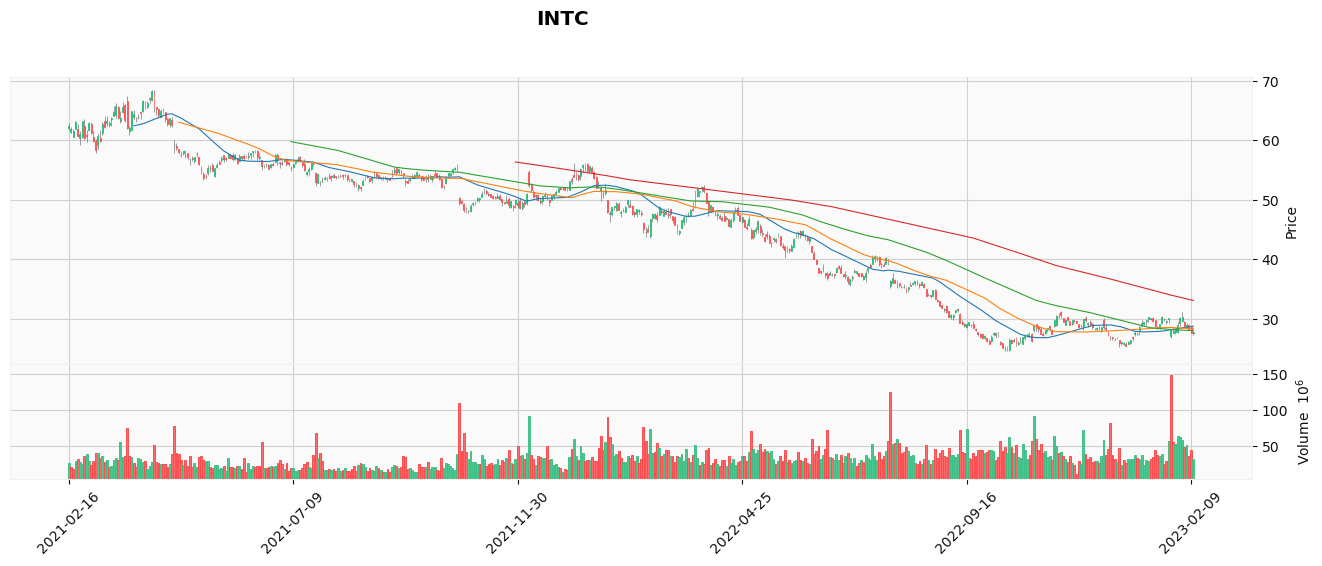

In [86]:
# create a candlestick plot for intel
intel_df = stock_dfs['INTC'].sort_index()
mplfinance.plot(intel_df[['open', 'high', 'low', 'close', 'volume']], type='candle', style='yahoo', volume=True, title='INTC', figratio=(15, 5), datetime_format='%Y-%m-%d', mav=(30, 50, 100, 200))

Save all the stock price tables

In [78]:
# save all the stock dataframes to csv files
os.makedirs('stock_data', exist_ok=True)
for stock, df in tqdm(stock_dfs.items()):
    df.to_csv('stock_data/{}.csv'.format(stock))

100%|██████████| 56/56 [00:00<00:00, 157.75it/s]
